### Simulation of cyan fluorescence in GFP populations using Discrete Time Markov Chains

In [1]:
rm(list = ls())

In [2]:
library("pracma")
library("flowCore")
library("caTools")
library("mixtools")
library("fitdistrplus")
library("SIBERG")
library("scatterplot3d") 


Attaching package: ‘caTools’


The following objects are masked from ‘package:pracma’:

    combs, trapz


mixtools package, version 1.2.0, Released 2020-02-05
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.


Loading required package: MASS

Loading required package: survival



In [3]:
Brightness=read.csv("amino_acid_genotypes_to_brightness.csv")

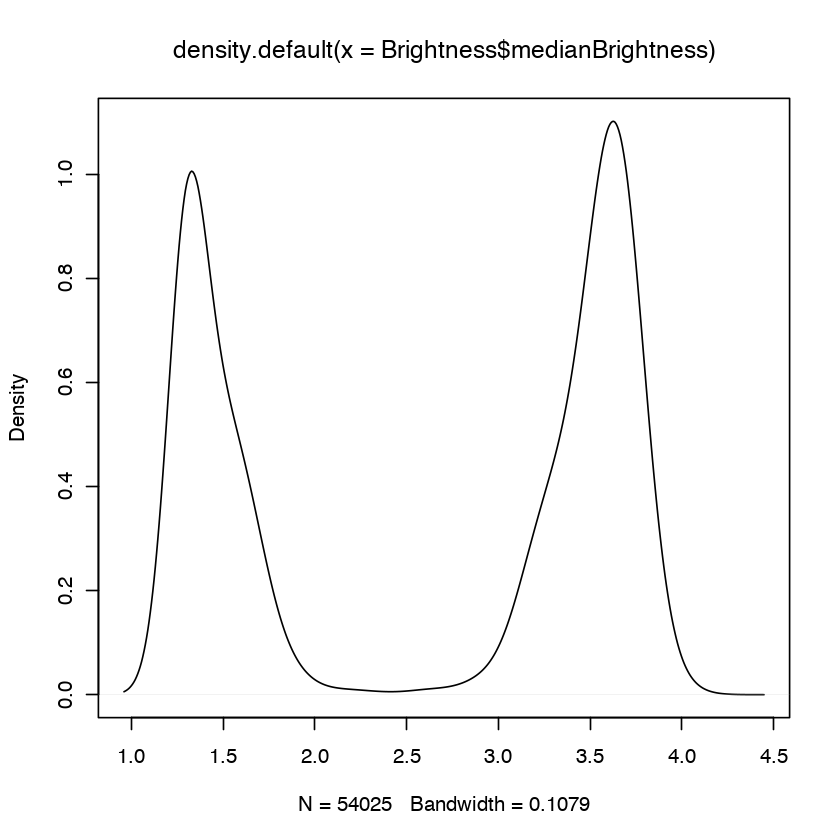

In [4]:
plot(density(Brightness$medianBrightness))

In [5]:
T=37;        #Temp in centigrade
R=1.98e-3;   #Gas constant in Kcal/K/mol
beta=1/(R*(273+T));   #Boltzman constant

In [6]:
DG=seq(-20, 0, 0.1)
F=exp(-beta*DG)/(1+exp(-beta*DG))

## Simulating the evolution GFP to Cyan 

In [7]:
YFP=Facs=read.FCS("~/Dropbox/Wagner_Lab/Projects/Landscape_modeling/Paper_1_Robustness_Foldability/wt_yfp_distribution/5bs24_D8_D08_036.fcs")
WT=read.FCS("~/Dropbox/Wagner_Lab/Projects/Landscape_modeling/Paper_1_Robustness_Foldability/wt_yfp_distribution/wt1_D9_D09_037.fcs")

##### Fluorescence

In [8]:
X=seq(0, 10, 0.1)
### Constants
P=matrix(0, nrow = length(X), ncol = length(X))

for (j in 1:length(X)){  ## Fill by row
       
data <- Facs@exprs[,8]
fit <- fitLN(data, base=10, eps=10, d=NULL, model='V', zeroPercentThr=0.2, logLikToLN=TRUE)

mu1 <- fit[1]*0.9
mu2 <- fit[2]*1.04
sigma1 <- fit[3]
sigma2 <-fit[4]
P1=0.23

    Xj=X[j]
    P_drift=P1*(1/sqrt(2*sigma1*sigma1*pi))*exp(-((X-mu1)^2)/(2*sigma1*sigma1))+(1-P1)*(1/sqrt(2*sigma2*sigma2*pi))*exp(-((X-Xj)^2)/(2*sigma2*sigma2));
    P_drift=P_drift/trapz(X,P_drift)
     
    P[j,] =P_drift

}

##### Stability

In [9]:
DG=seq(-20,0, 0.2)
States=seq(1, length(DG))

In [10]:
### Constants

T=37;        #Temp in centigrade
R=1.98e-3;   #Gas constant in Kcal/K/mol
beta=1/(R*(273+T));   #Boltzman constant
N=1e3;

### Defining the transition probability matrix
Q=matrix(0, nrow = length(DG), ncol = length(DG))

for (i in 1:length(Q[,1])){  ## Fill by row
    
    DG_WT=DG[i]
    DG_mut=DG
    DDG=DG-DG_WT
    
    ### DDG distribution
    
    mu1=0.54;
    sigma1=0.98;
    mu2=2.05;
    sigma2=1.91;
    P1=0.49;
    PDDG=P1*(1/sqrt(2*sigma1*sigma1*pi))*exp(-((DDG-mu1)^2)/(2*sigma1*sigma1))+(1-P1)*(1/sqrt(2*sigma2*sigma2*pi))*exp(-((DDG-mu2)^2)/(2*sigma2*sigma2));

    P_int=PDDG
    P_int=P_int/trapz(DDG, P_int)
    
    Q[i,]=P_int
    
}

In [11]:
# simulate discrete Markov chains according to transition matrix P
run.mc.sim <- function(P, num.iters, init_state) {
  
  # number of possible states
  num.states <- nrow(P)
  
  # stores the states X_t through time
  states     <- numeric(num.iters)

  # initialize variable for first state 
  states[1]    <- init_state

  for(t in 2:num.iters) {
    
    # probability vector to simulate next state X_{t+1}
    p  <- P[states[t-1], ]
    
    ## draw from multinomial and determine state
    states[t] <-  which(rmultinom(1, 1, p) == 1)
  }
  return(states)
}

In [13]:
Stability=list()
n=0

limit=10
colfunc<-colorRampPalette(c("blue","red"))
cols=colfunc(limit)

for (thr in 1:limit){
States=seq(1, length(DG))

mean_q= thr*2 
sd_q=0.4*mean_q

num.chains     <- 10000
num.iterations <- 2
chain.states_P <- matrix(NA, ncol=num.chains, nrow=num.iterations)
chain.states_Q <- matrix(NA, ncol=num.chains, nrow=num.iterations)
X_mean=X_sd=K_mean=K_sd=DG_mean=DG_sd=rep(0, num.iterations)
Q_mean=P_mean=rep(0, 50)

num.generations=6
init_p=60
init_q=30

    
FL_list=P_list=Q_list=list()

for (super in 1:num.generations){

P_states <- matrix(NA, ncol=num.chains, nrow=50)
Q_states <- matrix(NA, ncol=num.chains, nrow=50)
P_list=list()
Q_list=list()
    
for(c in seq_len(num.chains)){
  chain.states_P[,c] <- run.mc.sim(P, num.iters = num.iterations, init_state = init_p)
  chain.states_Q[,c] <- run.mc.sim(Q, num.iters = num.iterations, init_state = init_q)     
}
  
    
DG_pop=DG[chain.states_Q[num.iterations,]]
stab_factor_pop=1/(1+exp(DG_pop+20))

Additive_A=rlnorm(length(DG_pop), meanlog = mean_q, sdlog = sd_q) ## with variation

Additive_A[which(Additive_A<0)]=NA
    
FL_pop=rep(3, length(DG_pop))
        
FL= Additive_A  + log(stab_factor_pop) + X[chain.states_P[num.iterations,]]

FL_linear=Additive_A*stab_factor_pop #exp(FL)
    

##Top fluorescence
index_keep=which((FL_linear > quantile(FL_linear, probs =0.9, na.rm = TRUE)))  


       
## Plot the situation at generation 20
if (super==20){

par(mfrow = c(1,3), pty="s")
label=paste("A=", as.character(mean_q))
plot(Additive_A, DG_pop, col="gray", main=label)
lines(Additive_A[index_keep],DG_pop[index_keep],  col="red", type="p", pch=19)

plot(Additive_A, FL_linear, type="p",col="gray")
lines(Additive_A[index_keep], FL_linear[index_keep],  type="p", pch=19, col="red")

plot(DG_pop, FL_linear, type="p", col="gray")
lines(DG_pop[index_keep], FL_linear[index_keep],  type="p", pch=19, col="red")
 
    
}
    
       
if (length(index_keep) > 0) {
    
if (length(index_keep)>0){
   FL_list[[super]]=FL[index_keep] 
   
}    

    init_p=round(mean(chain.states_P[num.iterations ,index_keep], na.rm = TRUE))
    init_q=round(mean(chain.states_Q[num.iterations ,index_keep], na.rm = TRUE))
    
    P_states[super,index_keep]=chain.states_P[num.iterations ,index_keep]
    Q_states[super,index_keep]=chain.states_Q[num.iterations ,index_keep]
    
    P_list[[super]]=chain.states_P[num.iterations ,index_keep]
    Q_list[[super]]=chain.states_Q[num.iterations ,index_keep]
         
    X_mean[super]=mean(FL_list[[super]], na.rm = TRUE)
    X_sd[super]=sd(FL_list[[super]], na.rm = TRUE)
    
    K_mean[super]=mean(X[P_list[[super]]], na.rm = TRUE)
    K_sd[super]=sd(X[P_list[[super]]], na.rm = TRUE)
    
    DG_mean[super]=mean(DG[Q_list[[super]]], na.rm = TRUE)
    DG_sd[super]=sd(DG[Q_list[[super]]], na.rm = TRUE)
    
    
} else {
    
    message ("Selection purged the initial state")
}
        
}
    
Stability[[thr]]=DG[Q_list[[super]]]

}

In [14]:
i=1
dose=1+1*i
DOSE=rep(dose, length(Stability[[i]]))
MAT=cbind(DOSE, Stability[[i]])
         
for (i in 2:10){
    
dose=1+0.5*i

DOSE=rep(dose, length(Stability[[i]]))

MAT=rbind(MAT, cbind(DOSE, Stability[[i]]))
    
}

colnames(MAT)=c("Abundance","Stability")
MAT=as.data.frame(MAT)

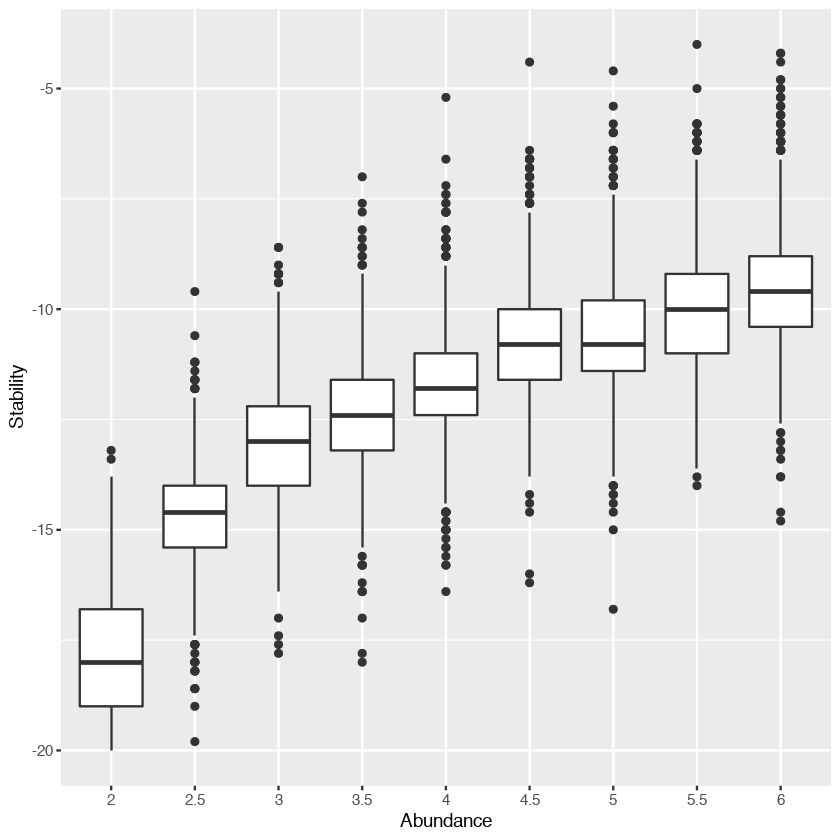

In [15]:
library(ggplot2)

#pdf("Stability_Abundance_Selection_0.9_no_f_.pdf")
MAT$Abundance <- as.factor(MAT$Abundance)
# Basic box plot
p <- ggplot(MAT, aes(x=Abundance, y=Stability)) + 
  geom_boxplot()
p
#dev.off()

In [68]:
selec_iter_number=7
rounds=10


Stab_MAT_avg=matrix(NA, nrow = selec_iter_number, ncol=rounds)
Stab_MAT_sd=matrix(NA, nrow = selec_iter_number, ncol=rounds)

selection=c(0, 0.2, 0.4, 0.6, 0.8, 0.90, 0.999)

for (iter in 1:selec_iter_number){
        
message(paste("Iteration=", as.character(iter)))
    
Stability=list()

for (thr in 1:rounds){

States=seq(1, length(DG))

mean_q= 2+thr
sd_q=0.3*mean_q

num.chains     <- 10000
num.iterations <- 2
chain.states_P <- matrix(NA, ncol=num.chains, nrow=num.iterations)
chain.states_Q <- matrix(NA, ncol=num.chains, nrow=num.iterations)
X_mean=X_sd=K_mean=K_sd=DG_mean=DG_sd=rep(0, num.iterations)
Q_mean=P_mean=rep(0, 50)

    
num.generations=20
init_p=60
init_q=30

    
FL_list=P_list=Q_list=list()

for (super in 1:num.generations){

P_states <- matrix(NA, ncol=num.chains, nrow=50)
Q_states <- matrix(NA, ncol=num.chains, nrow=50)
P_list=list()
Q_list=list()
    
for(c in seq_len(num.chains)){
  chain.states_P[,c] <- run.mc.sim(P, num.iters = num.iterations, init_state = init_p)
  chain.states_Q[,c] <- run.mc.sim(Q, num.iters = num.iterations, init_state = init_q)     
}
  
    
DG_pop=DG[chain.states_Q[num.iterations,]]
stab_factor_pop=1/(1+exp(DG_pop+12))

Additive_A=rlnorm(length(DG_pop), meanlog = mean_q, sdlog = sd_q) ## with variation

Additive_A[which(Additive_A<0)]=NA
    
FL_pop=rep(3, length(DG_pop))
        
FL= Additive_A  + log(stab_factor_pop) + X[chain.states_P[num.iterations,]]  

FL_linear=Additive_A*stab_factor_pop #exp(FL)

index_keep=which((FL_linear > quantile(FL_linear, probs = selection[iter], na.rm = TRUE) ) )  

        
if ( length(index_keep) >0 ) {
    
if (length(index_keep)>0){
   FL_list[[super]]=FL[index_keep] 
   
}    

    init_p=round(mean(chain.states_P[num.iterations ,index_keep], na.rm = TRUE))
    init_q=round(mean(chain.states_Q[num.iterations ,index_keep], na.rm = TRUE))
    
    P_states[super,index_keep]=chain.states_P[num.iterations ,index_keep]
    Q_states[super,index_keep]=chain.states_Q[num.iterations ,index_keep]
    
    P_list[[super]]=chain.states_P[num.iterations ,index_keep]
    Q_list[[super]]=chain.states_Q[num.iterations ,index_keep]
         
    X_mean[super]=mean(FL_list[[super]], na.rm = TRUE)
    X_sd[super]=sd(FL_list[[super]], na.rm = TRUE)
    
    K_mean[super]=mean(X[P_list[[super]]], na.rm = TRUE)
    K_sd[super]=sd(X[P_list[[super]]], na.rm = TRUE)
    
    DG_mean[super]=mean(DG[Q_list[[super]]], na.rm = TRUE)
    DG_sd[super]=sd(DG[Q_list[[super]]], na.rm = TRUE)
    
    
} else {
    
    message ("Selection purged the initial state")
}
        
}
    
Stability[[thr]]=DG[Q_list[[super]]]

}


   
for (i in 1:length(Stability)){
    
    Stab_MAT_avg[iter,i]=mean(Stability[[i]])
    Stab_MAT_sd[iter,i]=sd(Stability[[i]])
      
}
    
    
    
}

Iteration= 1

Iteration= 2

Iteration= 3

Iteration= 4

Iteration= 5

Iteration= 6

Iteration= 7



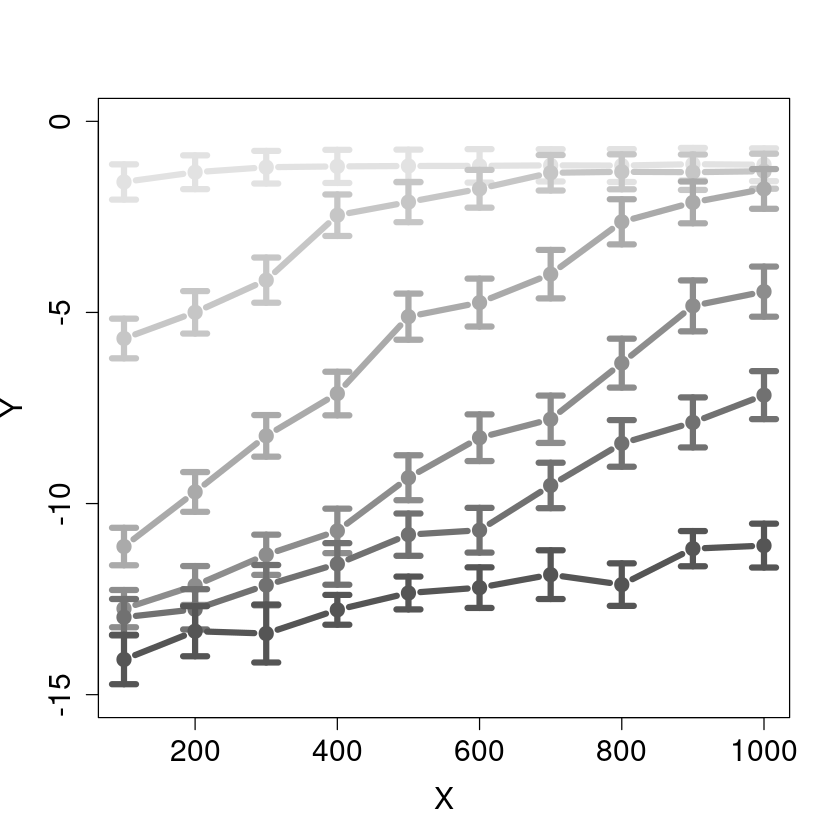

In [76]:
#pdf("Abundance_selection.pdf")
colfunc <- colorRampPalette(c("white", "black"))
cols=colfunc(rounds)

X=100*seq(1,rounds)

for (i in 1:dim(Stab_MAT_avg)[1]){
    
   Y= Stab_MAT_avg[i,]
   Y_sd= Stab_MAT_sd[i,]
    
    if (i==1){
        
        plot(X, Y, type="b", ylim=c(-15,0), col=cols[1], lwd=5, cex.axis=1.5, cex.lab=1.5, pch=19)
        arrows(X, Y - Y_sd/2, X, Y + Y_sd/2, code=3, col=cols[1], lwd=5, angle = 90, length = 0.1)


    } else {
        
        lines(X, Y, col=cols[i], lwd=5, type="b", pch=19)
        arrows(X, Y - Y_sd/2, X, Y + Y_sd/2, code=3, col=cols[i], lwd=5, angle = 90, length = 0.1)

    }
    
}

#dev.off()